# Sport Vouchers Program Analysis

The goal of this Portfolio task is to explore data from the Federal Government Sport Vouchers program - this is a
program that provides up to two $100 vouchers for kids to participate in organised sport. Here's the [NSW Active Kids page](https://www.service.nsw.gov.au/transaction/apply-active-kids-voucher), there are similar schemes in other states - this data is from South Australia.

This is an exercise in exploring data and communicating the insights you can gain from it.  The source data comes
from the `data.gov.au` website and provides details of all Sport Vouchers that have been redeemed since February  in SA 2015 as part of the Sport Voucher program:  [Sports Vouchers Data](https://data.gov.au/dataset/ds-sa-14daba50-04ff-46c6-8468-9fa593b9f100/details).  This download is provided for you as `sportsvouchersclaimed.csv`.

To augment this data you can also make use of [ABS SEIFA data by LGA](http://stat.data.abs.gov.au/Index.aspx?DataSetCode=ABS_SEIFA_LGA#) which shows a few measures of Socioeconomic Advantage and Disadvantage for every Local Government Area. This data is provided for you as `ABS_SEIFA_LGA.csv`. This could enable you to answer questions about whether the voucher program is used equally by parents in low, middle and high socioeconomic areas.   You might be interested in this if you were concerned that this kind of program might just benifit parents who are already advantaged (they might already be paying for sport so this program wouldn't be helping much).

Questions:
* Describe the distribution of vouchers by: LGA, Sport - which regions/sports stand out? 
* Are some sports more popular in different parts of the state?
* Are any LGAs over/under represented in their use of vouchers?
* Is there a relationship between any of the SEIFA measures and voucher use in an LGA?

A challenge in this task is to display a useful summary of the data given that there are a large number of LGAs and sports involved.  Try to avoid long lists and large tables. Think about what plots and tables communicate the main points of your findings. 


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
# read the sports vouchers data
sa_vouchers = pd.read_csv("files/sportsvouchersclaimed.csv")
sa_vouchers.head()

,Participant_ID,Participant_Suburb,Club_Previous_Member,Participant_ATSI_Indicator,Participant_CALD_Indicator,Participant_Sex,Voucher_Value,Club_Name,Voucher_Sport,Participant_LGA,Participant_Electorate,Voucher_Completion_Date,Voucher_Claim_Year
0,1000002,ABERFOYLE PARK,Registered Previously,Not ATSI,Not CALD,Male,50,Flagstaff Hill Football Club,Australian Rules,ONKAPARINGA,FISHER,26/6/15 1:19,2015
1,1000002,ABERFOYLE PARK,Registered Previously,Not ATSI,Not CALD,Male,50,Flagstaff Hill Football Club,Australian Rules,ONKAPARINGA,FISHER,29/6/16 23:55,2016
2,1000004,ABERFOYLE PARK,Not Registered Previously,Not ATSI,Not CALD,Female,50,Hub Gymnastics Club,Gymnastics,ONKAPARINGA,FISHER,21/4/16 3:37,2016
3,1000004,ABERFOYLE PARK,Registered Previously,Not ATSI,Not CALD,Female,50,Hub Gymnastics Club,Gymnastics,ONKAPARINGA,FISHER,30/3/17 0:47,2017
4,1000005,ABERFOYLE PARK,Registered Previously,Not ATSI,Not CALD,Female,50,Blackwood Community Recreation Association,Gymnastics,ONKAPARINGA,FISHER,20/7/15 2:50,2015


The SEIFA data includes row for each Local Government Area (LGA) but the names of the LGAs have a letter or letters in brackets after the name.  To allow us to match this up with the voucher data we remove this and convert to uppercase. 

For each LGA the data includes a number of measures all of which could be useful in your exploration.  

In [4]:
# read the SEIFA data, create an LGA column by removing the letters in brackets and converting to uppercase
seifa = pd.read_csv('files/ABS_SEIFA_LGA.csv')
lga = seifa["Local Government Areas - 2011"].str.replace(' \([ACSRCDMT]+\)', '').str.upper()
seifa['LGA'] = lga
seifa.head()

<ipython-input-4-8c32cb05a179>:3: FutureWarning: The default value of regex will change from True to False in a future version.
  lga = seifa["Local Government Areas - 2011"].str.replace(' \([ACSRCDMT]+\)', '').str.upper()


,LGA_2011,Local Government Areas - 2011,INDEX_TYPE,Index Type,MEASURE,Measure,Value,LGA
0,10050,Albury (C),IRSAD,Index of Relative Socio-economic Advantage and...,SCORE,Score,967,ALBURY
1,10050,Albury (C),IRSAD,Index of Relative Socio-economic Advantage and...,MINS,Minimum score for SA1s in area,628,ALBURY
2,10050,Albury (C),IRSAD,Index of Relative Socio-economic Advantage and...,MAXS,Maximum score for SA1s in area,1169,ALBURY
3,10050,Albury (C),IRSAD,Index of Relative Socio-economic Advantage and...,URP,Usual resident population,47851,ALBURY
4,10110,Armidale Dumaresq (A),IRSAD,Index of Relative Socio-economic Advantage and...,SCORE,Score,985,ARMIDALE DUMARESQ


Since there are many rows per LGA we need to use `pivot_table` to create a new data frame with one row per LGA. Here
is an example of doing this to create a table with the different SCORE measures and the population (URP) field. 

In [5]:
LGA_scores = seifa[seifa.MEASURE == 'SCORE'].pivot_table(index="LGA", columns=["INDEX_TYPE"], values="Value")
LGA_scores.head()
LGA_pop = seifa[seifa.MEASURE == 'URP'].pivot_table(index="LGA", columns=["INDEX_TYPE"], values="Value")
LGA_scores['Population'] = LGA_pop.IEO
LGA_scores.head()

INDEX_TYPE,IEO,IER,IRSAD,IRSD,Population
LGA,,,,,
ADELAIDE,874.0,874.0,1036.0,1013.0,19606.0
ADELAIDE HILLS,1083.0,1083.0,1077.0,1081.0,38601.0
ALBANY,999.0,999.0,977.0,987.0,33614.0
ALBURY,964.0,964.0,967.0,979.0,47851.0
ALEXANDRINA,1000.0,1000.0,969.0,987.0,23693.0


This data frame can then be joined with the vouchers data fram to create one master data frame containing both the voucher data and the SEIFA measures.

In [6]:
sa_vouchers_scores = sa_vouchers.join(LGA_scores, on='Participant_LGA')
sa_vouchers_scores.head()

,Participant_ID,Participant_Suburb,Club_Previous_Member,Participant_ATSI_Indicator,Participant_CALD_Indicator,Participant_Sex,Voucher_Value,Club_Name,Voucher_Sport,Participant_LGA,Participant_Electorate,Voucher_Completion_Date,Voucher_Claim_Year,IEO,IER,IRSAD,IRSD,Population
0,1000002,ABERFOYLE PARK,Registered Previously,Not ATSI,Not CALD,Male,50,Flagstaff Hill Football Club,Australian Rules,ONKAPARINGA,FISHER,26/6/15 1:19,2015,996.0,996.0,975.0,993.0,159517.0
1,1000002,ABERFOYLE PARK,Registered Previously,Not ATSI,Not CALD,Male,50,Flagstaff Hill Football Club,Australian Rules,ONKAPARINGA,FISHER,29/6/16 23:55,2016,996.0,996.0,975.0,993.0,159517.0
2,1000004,ABERFOYLE PARK,Not Registered Previously,Not ATSI,Not CALD,Female,50,Hub Gymnastics Club,Gymnastics,ONKAPARINGA,FISHER,21/4/16 3:37,2016,996.0,996.0,975.0,993.0,159517.0
3,1000004,ABERFOYLE PARK,Registered Previously,Not ATSI,Not CALD,Female,50,Hub Gymnastics Club,Gymnastics,ONKAPARINGA,FISHER,30/3/17 0:47,2017,996.0,996.0,975.0,993.0,159517.0
4,1000005,ABERFOYLE PARK,Registered Previously,Not ATSI,Not CALD,Female,50,Blackwood Community Recreation Association,Gymnastics,ONKAPARINGA,FISHER,20/7/15 2:50,2015,996.0,996.0,975.0,993.0,159517.0


# Describe the distribution of vouchers by: LGA, Sport - which regions/sports stand out?

In [7]:
print(sa_vouchers_scores.shape)
print(sa_vouchers_scores.nunique())

(127526, 18)
Participant_ID                82469
Participant_Suburb             1220
Club_Previous_Member              2
Participant_ATSI_Indicator        2
Participant_CALD_Indicator        2
Participant_Sex                   2
Voucher_Value                    18
Club_Name                      1162
Voucher_Sport                    50
Participant_LGA                  69
Participant_Electorate           48
Voucher_Completion_Date         273
Voucher_Claim_Year                3
IEO                              53
IER                              53
IRSAD                            55
IRSD                             53
Population                       62
dtype: int64


Based on preliminary exploration of the dataset there are 127526 vouchers distributed among 69 LGAs with 50 sports to select from.


Top 5 LGAs by Vouchers
ONKAPARINGA       12782
SALISBURY          8169
TEA TREE GULLY     7219
PLAYFORD           6940
CHARLES STURT      6897
Name: Participant_LGA, dtype: int64 

Bottom 5 LGAs by Vouchers
COOBER PEDY           39
PETERBOROUGH          45
FLINDERS RANGES      102
ORROROO/CARRIETON    137
FRANKLIN HARBOUR     155
Name: Participant_LGA, dtype: int64
127526


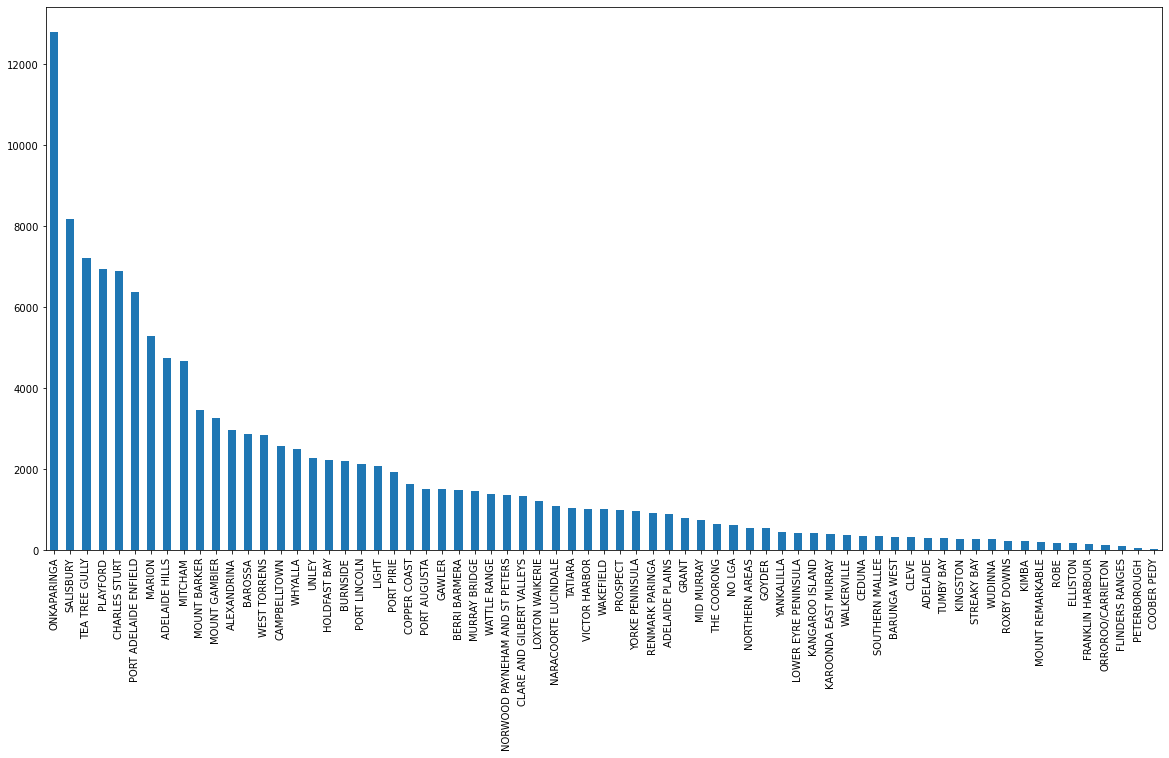

In [56]:
print('Top 5 LGAs by Vouchers')
zzyy=sa_vouchers_scores["Participant_LGA"].value_counts()
print((sa_vouchers_scores["Participant_LGA"].value_counts()).nlargest(5),"\n")

print('Bottom 5 LGAs by Vouchers')
print((sa_vouchers_scores["Participant_LGA"].value_counts()).nsmallest(5))

#Plot
ploterino = zzyy.plot(kind='bar',figsize =(20,10))
print((sa_vouchers_scores["Participant_LGA"]=='Adelaide').count())


The highest amount of vouchers are used by the ONKAPARINA LGA which has significantly higher voucher counts than the second highest the SALISBURY LGA; 12782/8169 = 1.56. ONKAPRINGA had ~56% more voucher usage.

Coober Pedy had the least amount of vouchers used (39/12782 = 0.3%) roughly 0.3% of the vouchers used by the top LGA of ONKAPARINGA. Peterborough is also an LGA of note as it has significantly less than the other bottom 5 similiar to COOBER PEDY.

The graph shows a clear skew towards the left indicating that a higher voucher distribution occured in the top few LGAs.

Top 5 Sports by Voucher Usage
Australian Rules     47224
Netball              24017
Football (Soccer)    15775
Gymnastics            9823
Basketball            6016
Name: Voucher_Sport, dtype: int64 

Bottom 5 Sports by Voucher Usage
Participant_ID                977
Participant_Suburb            977
Club_Previous_Member          977
Participant_ATSI_Indicator    977
Participant_CALD_Indicator    977
Participant_Sex               977
Voucher_Value                 977
Club_Name                     977
Voucher_Sport                 977
Participant_LGA               977
Participant_Electorate        977
Voucher_Completion_Date       975
Voucher_Claim_Year            977
IEO                           977
IER                           977
IRSAD                         977
IRSD                          977
Population                    977
vouche_total                  977
dtype: int64


<AxesSubplot:>

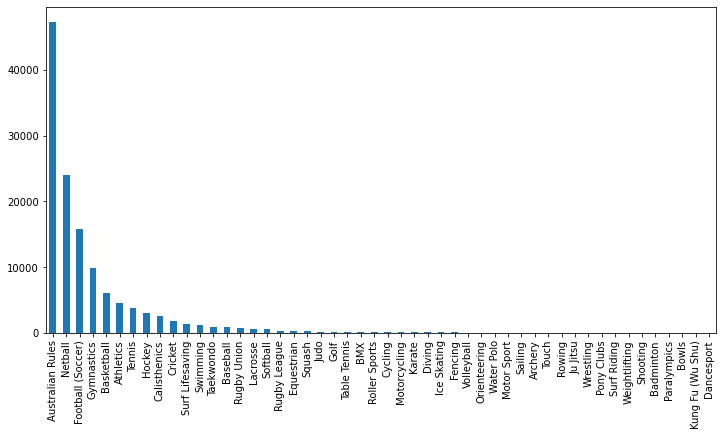

In [98]:
print('Top 5 Sports by Voucher Usage')
print((sa_vouchers_scores["Voucher_Sport"].value_counts()).nlargest(5),"\n")
xxyy= sa_vouchers_scores["Voucher_Sport"].value_counts()

print('Bottom 5 Sports by Voucher Usage')
pnewdf= sa_vouchers_scores.loc[sa_vouchers_scores["Participant_LGA"] == 'YORKE PENINSULA']
print(pnewdf.count())
#Plot
xxyy.plot(kind='bar',figsize =(12,6))

The most popular sport for vouchers is by far Australian Rules which has significantly higher voucher usage than the second highest Netball; 47224/24017= 1.96.  Australian Rules was selected ~96% more than Netball.

The least popular sport for vouchers is bowls, kung fu and dancesports however the top 5 is closely related in terms of numbers.

Based on the graph it can be seen that out of the 50 sports approximately the vast majority of vouchers were used in the top 10 spots with the main concentration of voucher use being in Australian Rules, Netball and Football.

# Are some sports more popular in different parts of the state?

<AxesSubplot:xlabel='Participant_LGA', ylabel='Voucher_Sport'>

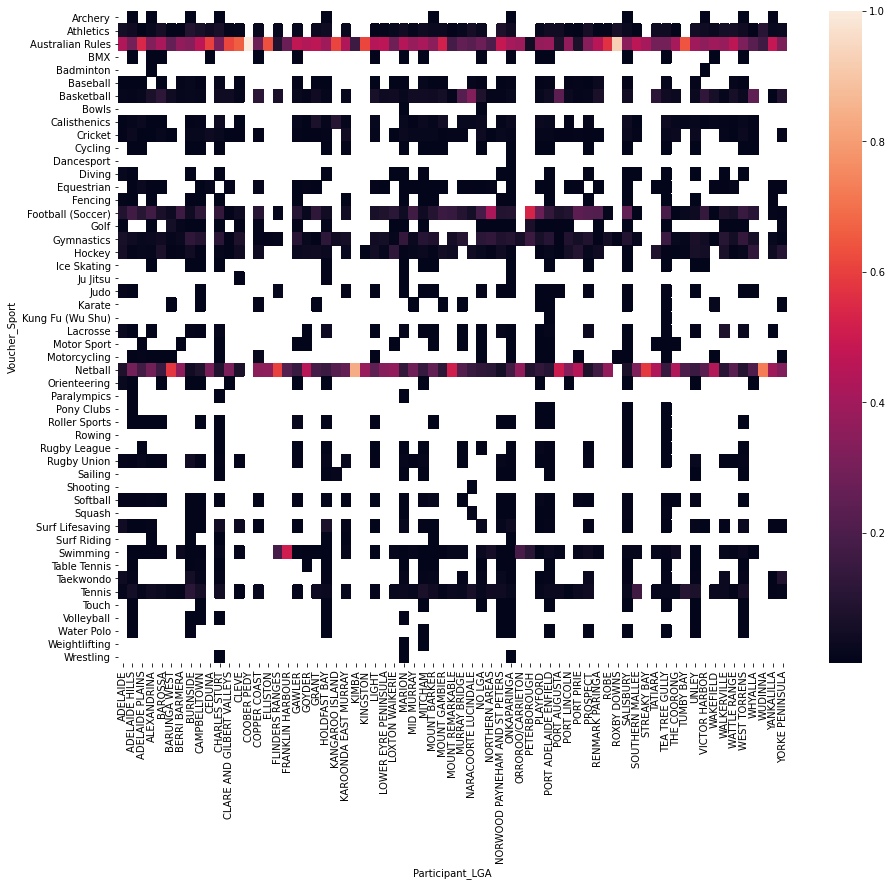

In [247]:

sa_vouchers_scores["vouche_total"] = sa_vouchers_scores.groupby(['Participant_LGA'])['Participant_LGA'].transform('count')

voucher_sport = sa_vouchers_scores.groupby(['Participant_LGA', 'Voucher_Sport',"vouche_total"]).size().reset_index()
voucher_sport['Perc'] = voucher_sport[0]/voucher_sport['vouche_total']
finalsports = voucher_sport.groupby(['Participant_LGA'])
#sports = pd.DataFrame({'count':voucher_sport.size()})
#testeros = voucher_sport.to_frame(name = 'test')
sports2 = voucher_sport.unstack(level=0)
#sports['total']= sports['count'].value_counts()
#sports['Perc'] = sports['count']/sports['vouche_total']
#finalioty= sports.groupby(['Participant_LGA']).sum()
#sportstester = sports.join(finalioty,on = "Participant_LGA")
#df['Counts'] = df.groupby(['Color'])['Value'].transform('count')

#print(sa_vouchers_scores.groupby(['Participant_LGA','Voucher_Sport']).count().groupby(level=).cumsum() )
newest=voucher_sport.drop(voucher_sport.columns[[2, 3]],1)
#ffs=voucher_sport = sa_vouchers_scores.groupby(['Participant_LGA', 'Voucher_Sport']).size()
#testeros=sports.groupby(['Participant_LGA'])
#print(newest)
newest2 = newest.pivot(index='Voucher_Sport', columns='Participant_LGA', values='Perc')
#print(newest2)
#sports['LGATOTAL'] = testeros.sum()
#print(testeros.sum())
#sport_count = pd.Dataframe({})
#qld_vouchers_scores = qld_vouchers.join(LGA_scores, on='LGA')
fig, ax = plt.subplots(figsize =(15,12))
sns.heatmap(newest2, xticklabels=True,yticklabels =True)

# Are any LGAs over/under represented in their use of vouchers?

In the above explorations the LGAs with the most and least voucher distribution was identified, to identify if any LGA's are over or under represented the total vouchers were divided by the total population, LGA's with higher value counts than the expected vouchers based on population are over represented and vice versa for underrepresntation.

In [10]:
sa_vouchers_scores.isna().sum()

Participant_ID                   0
Participant_Suburb               0
Club_Previous_Member             0
Participant_ATSI_Indicator       0
Participant_CALD_Indicator       0
Participant_Sex                  0
Voucher_Value                    0
Club_Name                        0
Voucher_Sport                    0
Participant_LGA                  0
Participant_Electorate           0
Voucher_Completion_Date       2080
Voucher_Claim_Year               0
IEO                           9460
IER                           9460
IRSAD                         9460
IRSD                          9460
Population                    9460
dtype: int64

In [11]:
sa_vouchers_scores.shape

(127526, 18)

In [12]:
clean_sa_vouchers = sa_vouchers_scores.dropna(axis=0)

In [13]:
clean_sa_vouchers.shape

(116229, 18)

As can be seen there are NaN values for certain LGA's population column. The NaN values will be dropped to create a cleaner data set that better represents the overlying data. The rows deleted will amount to 9460 from a total of 127526.

In [14]:
trail=clean_sa_vouchers.groupby(["Participant_LGA"])

In [46]:
trail['Population'].mean()

Participant_LGA
ADELAIDE           19606.0
ADELAIDE HILLS     38601.0
ALEXANDRINA        23693.0
BAROSSA            22174.0
BARUNGA WEST        2467.0
                    ...   
WEST TORRENS       54932.0
WHYALLA            22070.0
WUDINNA             1256.0
YANKALILLA          4406.0
YORKE PENINSULA    11046.0
Name: Population, Length: 62, dtype: float64

In [47]:
clean_sa_vouchers

,Participant_ID,Participant_Suburb,Club_Previous_Member,Participant_ATSI_Indicator,Participant_CALD_Indicator,Participant_Sex,Voucher_Value,Club_Name,Voucher_Sport,Participant_LGA,Participant_Electorate,Voucher_Completion_Date,Voucher_Claim_Year,IEO,IER,IRSAD,IRSD,Population
0,1000002,ABERFOYLE PARK,Registered Previously,Not ATSI,Not CALD,Male,50,Flagstaff Hill Football Club,Australian Rules,ONKAPARINGA,FISHER,26/6/15 1:19,2015,996.0,996.0,975.0,993.0,159517.0
1,1000002,ABERFOYLE PARK,Registered Previously,Not ATSI,Not CALD,Male,50,Flagstaff Hill Football Club,Australian Rules,ONKAPARINGA,FISHER,29/6/16 23:55,2016,996.0,996.0,975.0,993.0,159517.0
2,1000004,ABERFOYLE PARK,Not Registered Previously,Not ATSI,Not CALD,Female,50,Hub Gymnastics Club,Gymnastics,ONKAPARINGA,FISHER,21/4/16 3:37,2016,996.0,996.0,975.0,993.0,159517.0
3,1000004,ABERFOYLE PARK,Registered Previously,Not ATSI,Not CALD,Female,50,Hub Gymnastics Club,Gymnastics,ONKAPARINGA,FISHER,30/3/17 0:47,2017,996.0,996.0,975.0,993.0,159517.0
4,1000005,ABERFOYLE PARK,Registered Previously,Not ATSI,Not CALD,Female,50,Blackwood Community Recreation Association,Gymnastics,ONKAPARINGA,FISHER,20/7/15 2:50,2015,996.0,996.0,975.0,993.0,159517.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127521,1127524,ZADOWS LANDING,Registered Previously,Not ATSI,Not CALD,Female,50,Mannum Roos Netball Club,Netball,MID MURRAY,SCHUBERT,15/8/16 1:33,2016,965.0,965.0,917.0,937.0,8134.0
127522,1127524,ZADOWS LANDING,Registered Previously,Not ATSI,Not CALD,Female,50,Mannum Roos Netball Club,Netball,MID MURRAY,SCHUBERT,13/7/15 23:42,2015,965.0,965.0,917.0,937.0,8134.0
127523,1127524,ZADOWS LANDING,Registered Previously,Not ATSI,Not CALD,Female,50,Mannum Roos Netball Club,Netball,MID MURRAY,SCHUBERT,30/6/17 6:07,2017,965.0,965.0,917.0,937.0,8134.0
127524,1127526,ZADOWS LANDING,Registered Previously,Not ATSI,Not CALD,Female,50,Mannum Roos Netball Club,Netball,MID MURRAY,SCHUBERT,28/4/15 0:06,2015,965.0,965.0,917.0,937.0,8134.0


In [48]:
newdf= trail['Participant_LGA'].count()

final = pd.DataFrame({'Voucher Count':newdf.values, 'Population':trail['Population'].mean() })
final['Population'] = trail['Population'].mean()

In [49]:
print(final)

                 Voucher Count  Population
Participant_LGA                           
ADELAIDE                   296     19606.0
ADELAIDE HILLS            4652     38601.0
ALEXANDRINA               2938     23693.0
BAROSSA                   2861     22174.0
BARUNGA WEST               332      2467.0
...                        ...         ...
WEST TORRENS              2806     54932.0
WHYALLA                   2439     22070.0
WUDINNA                    267      1256.0
YANKALILLA                 439      4406.0
YORKE PENINSULA            975     11046.0

[62 rows x 2 columns]


In [50]:
final['Voucher_per_pop'] = final['Voucher Count']/final['Population']

In [51]:
print(final)

                 Voucher Count  Population  Voucher_per_pop
Participant_LGA                                            
ADELAIDE                   296     19606.0         0.015097
ADELAIDE HILLS            4652     38601.0         0.120515
ALEXANDRINA               2938     23693.0         0.124003
BAROSSA                   2861     22174.0         0.129025
BARUNGA WEST               332      2467.0         0.134576
...                        ...         ...              ...
WEST TORRENS              2806     54932.0         0.051081
WHYALLA                   2439     22070.0         0.110512
WUDINNA                    267      1256.0         0.212580
YANKALILLA                 439      4406.0         0.099637
YORKE PENINSULA            975     11046.0         0.088267

[62 rows x 3 columns]


In [52]:
#final.drop(columns="Participant_LGA")

In [53]:
chino = final['Voucher_per_pop'].mean()
print(chino)

0.10189537805615707


all LGA's whos voucher per pop is above the mean is over represented

In [54]:
overrep = (final[final['Voucher_per_pop'] > (chino)])
underrep= (final[final['Voucher_per_pop'] < (chino)])


In [80]:
overrep.sort_values(by=['Voucher_per_pop'], inplace=True, ascending=False)
print(overrep.head())

underrep.sort_values(by=['Voucher_per_pop'], inplace=True, ascending=True)
print(underrep.head())

final['mean_delta'] = (final['Voucher_per_pop'] - chino)
print(final)
#sns.set(style='darkgrid')

                      Voucher Count  Population  Voucher_per_pop
Participant_LGA                                                 
KAROONDA EAST MURRAY            378      1035.0         0.365217
WUDINNA                         267      1256.0         0.212580
KIMBA                           211      1087.0         0.194112
CLEVE                           325      1729.0         0.187970
SOUTHERN MALLEE                 342      2097.0         0.163090
                 Voucher Count  Population  Voucher_per_pop
Participant_LGA                                            
KINGSTON                   288     72380.5         0.003979
ADELAIDE                   296     19606.0         0.015097
COOBER PEDY                 39      1694.0         0.023022
CAMPBELLTOWN              2513     97060.0         0.025891
PETERBOROUGH                45      1733.0         0.025967
                 Voucher Count  Population  Voucher_per_pop  mean_delta
Participant_LGA                                      

<ipython-input-80-55cb249a48a5>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  overrep.sort_values(by=['Voucher_per_pop'], inplace=True, ascending=False)
<ipython-input-80-55cb249a48a5>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  underrep.sort_values(by=['Voucher_per_pop'], inplace=True, ascending=True)


#sns.set(style='darkgrid')
plt.figure(figsize=(100,25))
sns.barplot(x=final.index, y='Voucher_per_pop', data=final,
            color='#3792CB', edgecolor= 'black',
            bottom=chino)  # <-- set the bottom of the bars


<AxesSubplot:xlabel='Participant_LGA'>

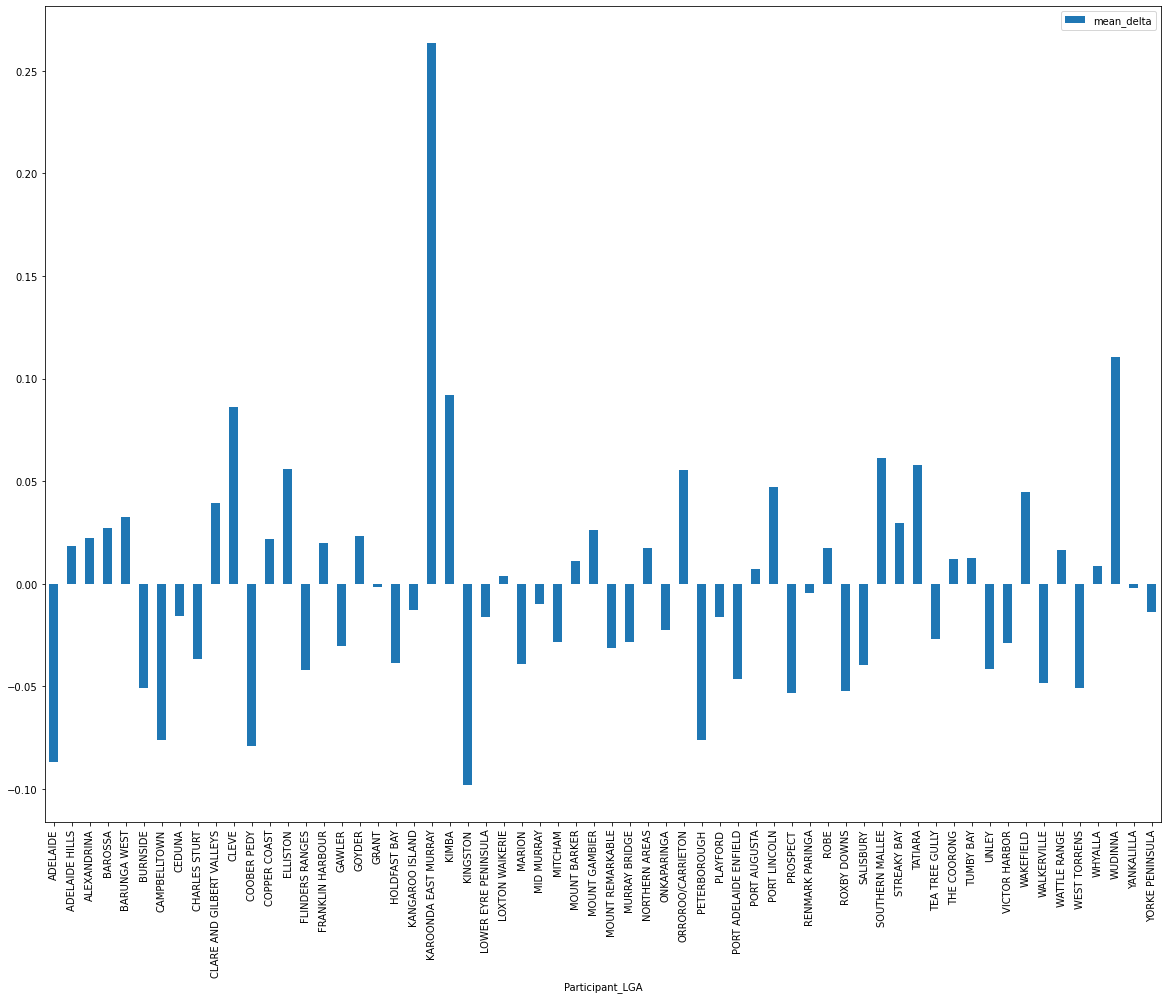

In [81]:
final.plot(kind = 'bar', y='mean_delta',figsize=(20,15) )

As can be seen certain areas have been significantly over represented in their usage of vouchers per population. Kingston and Adelaide have a significantly lower amount

# Is there a relationship between any of the SEIFA measures and voucher use in an LGA?

In [82]:
testLGA = pd.merge(final, LGA_scores, left_index=True, right_index=True)
testLGA=testLGA.drop(['Voucher Count'],axis =1)
testLGA=testLGA.drop(['Population_x'],axis =1)
testLGA=testLGA.drop(['Population_y'],axis =1)

In [83]:
print(testLGA)

                 Voucher_per_pop  mean_delta     IEO     IER   IRSAD    IRSD
ADELAIDE                0.015097   -0.086798   874.0   874.0  1036.0  1013.0
ADELAIDE HILLS          0.120515    0.018620  1083.0  1083.0  1077.0  1081.0
ALEXANDRINA             0.124003    0.022107  1000.0  1000.0   969.0   987.0
BAROSSA                 0.129025    0.027130  1028.0  1028.0   997.0  1017.0
BARUNGA WEST            0.134576    0.032681   981.0   981.0   940.0   954.0
...                          ...         ...     ...     ...     ...     ...
WEST TORRENS            0.051081   -0.050814   949.0   949.0   989.0   998.0
WHYALLA                 0.110512    0.008617   905.0   905.0   897.0   905.0
WUDINNA                 0.212580    0.110684  1008.0  1008.0   999.0  1023.0
YANKALILLA              0.099637   -0.002259   990.0   990.0   957.0   972.0
YORKE PENINSULA         0.088267   -0.013628   969.0   969.0   933.0   952.0

[62 rows x 6 columns]


<AxesSubplot:xlabel='Voucher_per_pop', ylabel='IRSD'>

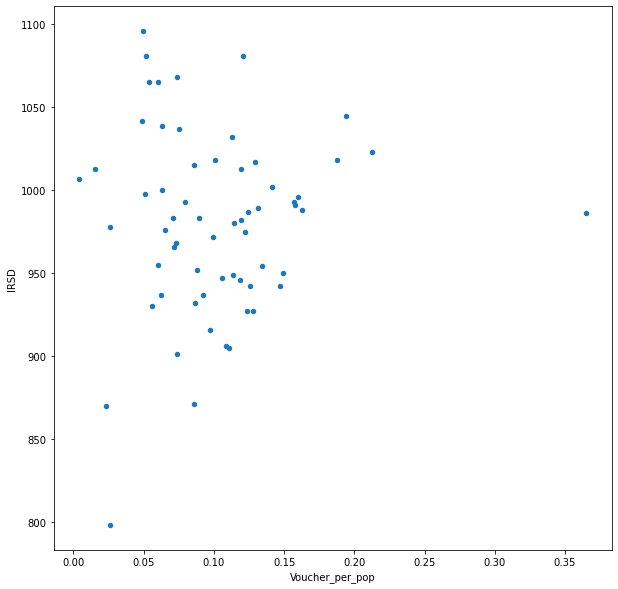

In [85]:
testLGA.sort_values(by=['Voucher_per_pop'], inplace=True, ascending=False)
testLGA.plot(kind = 'scatter',x='Voucher_per_pop',   y='IRSD',figsize=(10,10) )

In [89]:
corrIER = testLGA['Voucher_per_pop'].corr(testLGA['IER'])
corrIEO = testLGA['Voucher_per_pop'].corr(testLGA['IEO'])
corrIRSAD=testLGA['Voucher_per_pop'].corr(testLGA['IRSAD'])
corrIRSD=testLGA['Voucher_per_pop'].corr(testLGA['IRSD'])
print(corrIER)
print(corrIEO)
print(corrIRSAD)
print(corrIRSD)

0.25433683683488456
0.25433683683488456
-0.02882647108627505
0.06270914578322559


to further exmeplify the lack of correlation the correlation data shows that There appears to be no correlation between any of the IESAF

## Challenge - Queensland

_Note: this is an extra task that you might take on to get a better grade for your portfolio.  You can get a good pass grade without doing this._ 

Queensland has a similar program called [Get Started](https://data.gov.au/dataset/ds-qld-3118838a-d425-48fa-bfc9-bc615ddae44e/details?q=get%20started%20vouchers) and we can retrieve data from their program in a similar format.  

The file [round1-redeemed_get_started_vouchers.csv](files/round1-redeemed_get_started_vouchers.csv) contains records of the vouchers issued in Queensland. The date of this data is not included but the program started in 2015 so it is probably from around then.  

The data includes the LGA of the individual but the name of the activity is slightly different.  To do a comparable analysis you would need to map the activity names onto those from South Australia. 

In [27]:
qld_vouchers = pd.read_csv('files/round1-redeemed_get_started_vouchers.csv')
qld_vouchers.head()

,Application Number,Voucher Number,Child Age (at time of Application),Gender,Has your child played sport before?,Participation Activity,Club Name,Club Suburb/Town,Club Local Government Area Name,Club State Electoral District Name,Parent Suburb/Town,Total Payment
0,2000012253,Q89QDUXP,10,NaN,Yes,*Other,Queensland Police-Citizens Youth Welfare Assoc...,Airlie Beach,Whitsunday (R),Whitsunday,Jubilee Pocket,60.01
1,2000001727,593F6Y41,5,NaN,No,*Other,Guides Queensland,Windsor,Brisbane (C),Brisbane Central,Leichhardt,150.00
2,2000013464,PH2R4RTT,5,NaN,No,*Other,Guides Queensland,Windsor,Brisbane (C),Brisbane Central,Woodridge,150.00
3,2000009270,035SE2H5,5,NaN,Yes,*Other,Guides Queensland,Windsor,Brisbane (C),Brisbane Central,Yatala,150.00
4,2000007273,NP6C4729,6,NaN,No,*Other,Guides Queensland,Windsor,Brisbane (C),Brisbane Central,Alexandra Hills,150.00


In [28]:
# Join the QLD data with the LGA data as before to get population and SIEFA data integrated
qld_vouchers['LGA'] = qld_vouchers['Club Local Government Area Name'].str.replace(' \([RC]+\)', '').str.upper()
qld_vouchers_scores = qld_vouchers.join(LGA_scores, on='LGA')
qld_vouchers_scores.head()

<ipython-input-28-d688531e2bfc>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  qld_vouchers['LGA'] = qld_vouchers['Club Local Government Area Name'].str.replace(' \([RC]+\)', '').str.upper()


,Application Number,Voucher Number,Child Age (at time of Application),Gender,Has your child played sport before?,Participation Activity,Club Name,Club Suburb/Town,Club Local Government Area Name,Club State Electoral District Name,Parent Suburb/Town,Total Payment,LGA,IEO,IER,IRSAD,IRSD,Population
0,2000012253,Q89QDUXP,10,NaN,Yes,*Other,Queensland Police-Citizens Youth Welfare Assoc...,Airlie Beach,Whitsunday (R),Whitsunday,Jubilee Pocket,60.01,WHITSUNDAY,989.0,989.0,966.0,982.0,31393.0
1,2000001727,593F6Y41,5,NaN,No,*Other,Guides Queensland,Windsor,Brisbane (C),Brisbane Central,Leichhardt,150.00,BRISBANE,1018.0,1018.0,1057.0,1048.0,1042074.0
2,2000013464,PH2R4RTT,5,NaN,No,*Other,Guides Queensland,Windsor,Brisbane (C),Brisbane Central,Woodridge,150.00,BRISBANE,1018.0,1018.0,1057.0,1048.0,1042074.0
3,2000009270,035SE2H5,5,NaN,Yes,*Other,Guides Queensland,Windsor,Brisbane (C),Brisbane Central,Yatala,150.00,BRISBANE,1018.0,1018.0,1057.0,1048.0,1042074.0
4,2000007273,NP6C4729,6,NaN,No,*Other,Guides Queensland,Windsor,Brisbane (C),Brisbane Central,Alexandra Hills,150.00,BRISBANE,1018.0,1018.0,1057.0,1048.0,1042074.0
